# TO DO

1. Run the `Setup from GANS HW` cells. This just imports and defines a few things which we use to create the non-concept data sets.
2. Update the `directory` parameter in `Generate concept images` section.
3. Update the `directory` parameter in `Generate non-concept images` sectionß. Also update the `num_non_concept_data_sets` parameter, if necessary, in the `Generate non-concept images` cells below. If you do, make sure to also update the value of `num_random_concepts` in the`TCAV Viz` notebook.
2. Update the `directory` parameter in `Generate zebras` section.
3. Run the notebook in full!

## Setup from GANs HW

In [44]:
import tensorflow as tf
import numpy as np
import os
import imageio

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# A bunch of utility functions

def show_images(images, filename='stuff'):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,]))
    plt.savefig(filename+'.pdf', format='pdf', dpi=100)
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count

NOISE_DIM = 96

Wrapper around MNIST dataset downloaded from Google. As provided in the GANs HW

In [2]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, val = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        X, y = val
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.val_X, self.val_y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

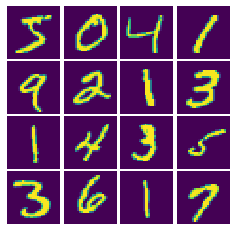

In [3]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

In [4]:
def add_rgb_dim(X):
    X = tf.reshape(X, (-1,28,28,1))
    colored_X = tf.image.grayscale_to_rgb(X)
    return colored_X

In [45]:
def show_images_color(images, filename='color_stuff'):
    print(images.shape)
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1]/3)))

    print(images.shape)
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    plt.savefig(filename+'.pdf', format='pdf', dpi=100)
    return

(16, 28, 28, 3)
(16, 2352)


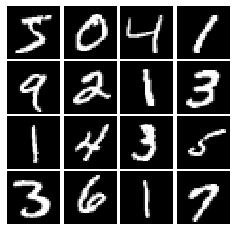

In [6]:
color_mnist = add_rgb_dim(mnist.X[:16])
show_images_color(color_mnist)

In [7]:
def colorize_images(X, y, mask, biases, targets):
    cmap = {}
    cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
    cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    
    colors = np.array([v for k,v in cmap.items()])
    N = X.shape[0]
    color_choice = np.random.choice(range(len(colors)), N)
    for bias, target in zip(biases, targets):
        bias_prob = 0.8
        shape = color_choice[y==target].shape
        color_choice[y==target] = tf.where(tf.random.uniform(shape=shape) < bias_prob,
                                           tf.ones(shape)*list(cmap.keys()).index(bias),
                                           color_choice[y==target])
    
    perturbation = tf.random.normal(X.shape, mean=0.0, stddev=0.1)
    
    mask = tf.reshape(mask, (-1,28,28,1)) # Mask from mnist
    
    color = tf.ones_like(X)*colors[color_choice]
    colored_X = X - (tf.ones_like(X) - (color+perturbation))*mask
    # Clip, because of the noise. Without noise, no clipping necessary
    colored_X = tf.where(colored_X<0, tf.zeros_like(colored_X), colored_X)
    colored_X = tf.where(colored_X>1, tf.ones_like(colored_X), colored_X)
    return colored_X, color_choice, cmap

(16, 28, 28, 3)
(16, 2352)


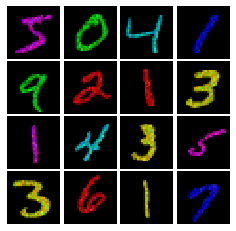

In [21]:
colored_X, color_choice, cmap = colorize_images(color_mnist, mnist.y[:16], mnist.X[:16], 
                                                biases=['RED', 'YELLOW', 'GREEN', 'MAGENTA', 'CYAN'], targets=[2,3,9,5,4])
show_images_color(colored_X)

## Helper functions

In [9]:
def make_dir(directory):
    os.makedirs(directory, exist_ok=True)

## Generate concept images
Here, concept images correspond to solid colored frames (i.e. all blue frame, no numbers).

In [24]:
def generate_color_concepts(batch_size, H, W, bias):
    cmap = {}
    cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
    cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    
    perturbation = tf.random.normal((batch_size, H, W, 3), mean=0.0, stddev=0.1)
    colored_frames = tf.ones((batch_size, H, W, 3))*cmap[bias] + perturbation
    # Clip, because of the noise. Without noise, no clipping necessary
    colored_frames = tf.where(colored_frames<0, tf.zeros_like(colored_frames), colored_frames)
    colored_frames = tf.where(colored_frames>1, tf.ones_like(colored_frames), colored_frames)
    
    return colored_frames

In [25]:
# WAIT!!! This cell was orginally used when we defined the "non-concept" as solid colored frames of all colors except the concept color.
# We have since switched to defining the "non-concept" as MNIST colored numbers of all colors except the concept color.
# For example, if the concept is blue, the "non-concept" data set includes numbers 0,...,9 colored red, green, yellow, cyan, and magenta.

# print("***********WARNGING WARNING WARNING***********")
# print("    read cell comments before continuing!!")
# print("**********************************************")

# def generate_random_color_concepts(batch_size, H, W, anti_biases):
#     cmap = {}
#     cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
#     cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
#     cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    
#     colors = np.array([v for k,v in cmap.items() if k not in anti_biases])
#     color_choice = np.random.choice(range(len(colors)), batch_size)
    
#     perturbation = tf.random.normal((batch_size, H, W, 3), mean=0.0, stddev=0.1)
#     not_colored_frames = tf.ones((batch_size, H, W, 3)) * colors[color_choice] + perturbation
#     # Clip, because of the noise. Without noise, no clipping necessary
#     not_colored_frames = tf.where(not_colored_frames<0, tf.zeros_like(not_colored_frames), not_colored_frames)
#     not_colored_frames = tf.where(not_colored_frames>1, tf.ones_like(not_colored_frames), not_colored_frames)
    
#     return not_colored_frames

In [26]:
batch_size = 200
H, W = 28, 28
bias = 'BLUE'
# anti_biases = [bias]

(16, 28, 28, 3)
(16, 2352)


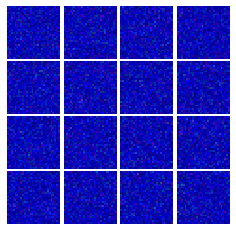

In [27]:
concept_frames = generate_color_concepts(batch_size, H, W, bias)
show_images_color(concept_frames[:16])

(16, 28, 28, 3)
(16, 2352)


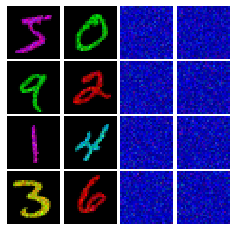

In [46]:
cav_viz = np.zeros_like(colored_X[:16])
right_idxs = np.array([0,1,4,5,8,9,12,13])
left_idxs = np.array([2,3,6,7,10,11,14,15])
cav_viz[right_idxs] = colored_X.numpy()[right_idxs]
cav_viz[left_idxs] = concept_frames.numpy()[left_idxs]
show_images_color(cav_viz, filename='cav_viz')

In [14]:
# not_concept_frames = generate_random_color_concepts(batch_size, H, W, anti_biases)
# show_images_color(not_concept_frames[:16])

### Note to J: update `directory` parameter in the cell below.

In [15]:
num_examples = 200
directory = '/Users/kessel/Documents/Stanford/2018_2019/Spring/CS231N/cs231n-project'
make_dir(directory + '/data/' + str(bias).lower())

for i in range(num_examples):
    name = directory + '/data/' + str(bias).lower() + '/' + str(i) + '.png'
    imageio.imwrite(name, concept_frames[i])
#     name = directory + '/data/not_' + str(bias).lower() + '/' + str(i) + '.png'
#     imageio.imwrite(name, not_concept_frames[i])

W0603 15:29:41.156544 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.158927 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.161247 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.163522 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.165753 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.167909 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:29:41.272695 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.275599 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.278534 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.281267 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.283723 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.286099 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:29:41.395220 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.397424 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.400079 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.402574 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.404567 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.406485 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:29:41.518229 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.520437 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.522799 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.525388 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.528247 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.531208 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:29:41.659226 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.661789 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.664459 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:29:41.667587 140735871599488 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


# Generate non-concept images
Here, non-concept images are MNIST colored numbers of all colors except the concept color. For example, if the concept is blue, the "non-concept" data set includes numbers 0,...,9 colored red, green, yellow, cyan, and magenta.

In [16]:
def add_rgb_dim_np(X):
    X = tf.reshape(X, (-1,28,28,1))
    colored_X = tf.image.grayscale_to_rgb(X)
    return colored_X.numpy()

In [17]:
def generate_not_concepts_like_training_data(X, mask, anti_biases):
    cmap = {}
    cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
    cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['BLUE'] = np.array([0,0,0.7], dtype=np.float32).reshape((1,1,3))
    
    colors = np.array([v for k,v in cmap.items() if k not in anti_biases])
    N = X.shape[0]
    color_choice = np.random.choice(range(len(colors)), N)
    
    perturbation = np.random.normal(loc=0.0, scale=0.1, size=X.shape)
    
    mask = np.reshape(mask, (-1,28,28,1)) # Mask from mnist

    color = np.ones_like(X) * colors[color_choice]
    colored_X = X - (np.ones_like(X) - (color + perturbation)) * mask
    # Clip, because of the noise. Without noise, no clipping necessary
    colored_X = np.where(colored_X < 0, np.zeros_like(colored_X), colored_X)
    colored_X = np.where(colored_X > 1, np.ones_like(colored_X), colored_X)
    return colored_X

In [18]:
batch_size = 200
bias = 'BLUE'
anti_biases = [bias]

mnist = MNIST(batch_size=batch_size)
color_mnist = add_rgb_dim_np(mnist.X)
not_concept_frames = generate_not_concepts_like_training_data(color_mnist, mnist.X, bias)

(16, 28, 28, 3)
(16, 2352)


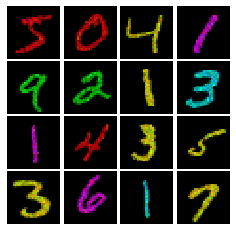

In [19]:
show_images_color(not_concept_frames[:16])

### Note to J: update `directory` parameter in the cell below.

In [20]:
num_non_concept_data_sets = 100
num_examples = 200
directory = '/Users/kessel/Documents/Stanford/2018_2019/Spring/CS231N/cs231n-project'

for d in range(num_non_concept_data_sets):
    mnist = MNIST(batch_size=batch_size)
    color_mnist = add_rgb_dim_np(mnist.X)
    not_concept_frames = generate_not_concepts_like_training_data(color_mnist, mnist.X, bias)
    make_dir(directory + '/data/not_' + str(bias).lower() + '_' + str(d))
    for i in range(num_examples):
        name = directory + '/data/not_' + str(bias).lower() + '_' + str(d) + '/' + str(i) + '.png'
        imageio.imwrite(name, not_concept_frames[i])

W0603 15:30:12.159667 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.162107 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.164261 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.166385 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.168652 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.171045 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:30:12.288666 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.291175 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.294107 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.297167 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.299582 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.302147 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:30:12.435672 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.438807 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.441678 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.445048 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.448333 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.450836 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:30:12.596154 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.599258 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.602564 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.605455 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.608597 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.611194 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:30:12.744555 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.748525 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.751361 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:12.754277 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.490240 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.493363 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:30:28.633496 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.637217 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.640730 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.643807 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.647695 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.650339 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:30:28.775461 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.778981 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.781743 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.785332 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.789002 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.792048 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:30:28.947135 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.949721 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.952383 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.954928 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.957833 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:28.960176 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:30:29.098880 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:29.102382 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:29.105159 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:29.108453 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:29.111704 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:30:29.114840 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

## Generate zebras
Here, zebras are blue 2s.

In [21]:
def add_rgb_dim_np(X):
    X = tf.reshape(X, (-1,28,28,1))
    colored_X = tf.image.grayscale_to_rgb(X)
    return colored_X.numpy()

In [22]:
def colorize_zebras(X, mask, bias):
    cmap = {}
#     cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
#     cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
#     cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['BLUE'] = np.array([0,0,0.7], dtype=np.float32).reshape((1,1,3))
    
    perturbation = np.random.normal(loc=0.0, scale=0.1, size=X.shape)
    
    mask = np.reshape(mask, (-1,28,28,1)) # Mask from mnist

    color = np.ones_like(X) * cmap[bias]
    colored_X = X - (np.ones_like(X) - (color + perturbation)) * mask
    # Clip, because of the noise. Without noise, no clipping necessary
    colored_X = np.where(colored_X < 0, np.zeros_like(colored_X), colored_X)
    colored_X = np.where(colored_X > 1, np.ones_like(colored_X), colored_X)
    return colored_X

In [23]:
batch_size = 200
bias = 'BLUE'
target = 2

mnist = MNIST(batch_size=batch_size)
color_mnist = add_rgb_dim_np(mnist.X)
idx = (mnist.y == target)
zebras = colorize_zebras(color_mnist[idx,], mnist.X[idx,], bias)

(16, 28, 28, 3)
(16, 2352)


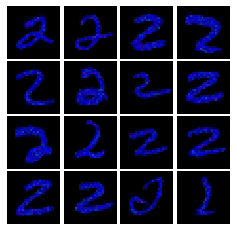

In [24]:
show_images_color(zebras[:16])

### Note to J: update `directory` parameter in the cell below.

In [26]:
directory = '/Users/kessel/Documents/Stanford/2018_2019/Spring/CS231N/cs231n-project'
make_dir(directory + '/data/all_blue_2s')
for i in range(batch_size):
    name = directory + '/data/all_blue_2s/' + str(i) + '.png'
    imageio.imwrite(name, zebras[i])

W0603 15:31:13.876801 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:13.879421 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:13.882169 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:13.885091 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:13.888746 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:13.891482 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:31:14.048698 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.053287 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.056572 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.060346 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.064464 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.069008 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:31:14.223417 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.226706 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.229560 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.232563 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.236174 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.239823 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:31:14.390516 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.393039 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.395638 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.398622 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.401684 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.405297 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

W0603 15:31:14.546778 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.550160 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.553289 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0603 15:31:14.556473 140735871599488 util.py:64] Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [27]:
# def colorize_balanced_zebras(X, mask):
#     cmap = {}
#     cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
#     cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
#     cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
#     cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
#     cmap['BLUE'] = np.array([0,0,0.7], dtype=np.float32).reshape((1,1,3))
    
#     colors = np.array([v for k,v in cmap.items()])
#     N = X.shape[0]
#     color_choice = np.random.choice(range(len(colors)), N)
    
#     perturbation = np.random.normal(loc=0.0, scale=0.1, size=X.shape)
    
#     mask = np.reshape(mask, (-1,28,28,1)) # Mask from mnist

#     color = np.ones_like(X) * colors[color_choice]
#     colored_X = X - (np.ones_like(X) - (color + perturbation)) * mask
#     # Clip, because of the noise. Without noise, no clipping necessary
#     colored_X = np.where(colored_X < 0, np.zeros_like(colored_X), colored_X)
#     colored_X = np.where(colored_X > 1, np.ones_like(colored_X), colored_X)
#     return colored_X

In [28]:
# batch_size = 200
# bias = 'BLUE'
# target = 2

# mnist = MNIST(batch_size=batch_size)
# color_mnist = add_rgb_dim_np(mnist.X)
# idx = (mnist.y == target)
# zebras = colorize_balanced_zebras(color_mnist[idx,], mnist.X[idx,])

In [29]:
# show_images_color(zebras[:16])

In [30]:
# directory = './'
# for i in range(batch_size):
#     name = directory + '/data/zebras_balanced/' + str(i) + '.png'
#     imageio.imwrite(name, zebras[i])